Import datasets

In [2]:
import pickle

with open('post_dfs.pkl', 'rb') as file:
    post_ct_df_list = pickle.load(file)
    
with open('pre_dfs.pkl', 'rb') as file:
    pre_ct_df_list = pickle.load(file)
    
with open('segmentation_dfs.pkl', 'rb') as file:
    segmentation_df_list = pickle.load(file)
    

Load display functions

In [3]:
# Example display patient

i = 25
df = segmentation_df_list[i]
    
df_ct = pre_ct_df_list[i]
    
df_ct2 = post_ct_df_list[i]


In [4]:
import cv2
import ipywidgets as widgets
from IPython.display import display
import os
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap



def display_image(i, j):
    uid_code = df_ct['UID'].iloc[i]

    segmentations = df[df['UID'] == uid_code]

    f, axarr = plt.subplots(1,2, figsize=(10, 14))
    axarr[0].imshow(df_ct['pixel_array'].iloc[i], cmap=plt.cm.bone)
    axarr[1].imshow(df_ct['pixel_array'].iloc[j], cmap=plt.cm.bone)

    color_list = ['red', 'green', 'blue', 'yellow']
    labels = ["Liver", "Mass", "Portal vein", "Abdominal aorta"]
    patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, color_list)]
    plt.legend(handles=patches, bbox_to_anchor=(1.8, 1))

    if len(segmentations) > 0:
        for segment in segmentations.iterrows():
            liver_mask = np.where(segment[1]['pixel_array'] != 0, segment[1]['label'], 0)
            liver_mask = np.ma.masked_where(liver_mask == 0, liver_mask)
            axarr[0].imshow(liver_mask, cmap=ListedColormap(color_list[segment[1]['label']-1]), alpha=0.5)

# slider1 = widgets.IntSlider(min=0, max=len(df_ct)-1, step=1, value=0)
# slider2 = widgets.IntSlider(min=0, max=len(df_ct2)-1, step=1, value=0)
# widgets.interact(display_image, i=slider1, j=slider2)

In [5]:
def dashboard_display(i):
    
    df = segmentation_df_list[i]
    
    df_ct = pre_ct_df_list[i]
    
    df_ct2 = post_ct_df_list[i]
    
    slider1 = widgets.IntSlider(min=0, max=len(df_ct)-1, step=1, value=0)
    slider2 = widgets.IntSlider(min=0, max=len(df_ct2)-1, step=1, value=0)
    widgets.interact(display_image, i=slider1, j=slider2)

In [6]:
dashboard_display(i)

interactive(children=(IntSlider(value=0, description='i', max=72), IntSlider(value=0, description='j', max=80)…

Search section with most visible cancer mass

UID            1.3.6.1.4.1.14519.5.2.1.1706.8374.199743050706...
label                                                          2
pixel_array    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: 119, dtype: object
2355


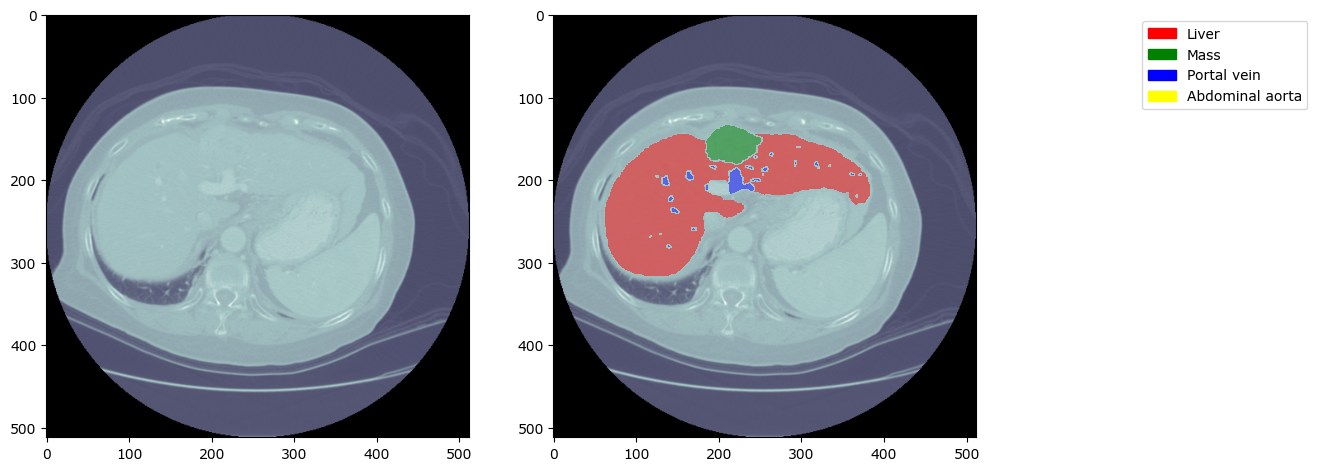

                                                  UID  \
26  1.3.6.1.4.1.14519.5.2.1.1706.8374.199743050706...   

                                          pixel_array  
26  [[-1024, -1024, -1024, -1024, -1024, -1024, -1...  


In [7]:
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def plot_max_cancer_mass_section(index):
    df = segmentation_df_list[index]
    
    # Label 2 is cancer mass

    df_label_2 = df[df['label'] == 2]
    max_val_index = df_label_2['pixel_array'].apply(np.sum).idxmax()
    max_val_row = df_label_2.loc[max_val_index]

    print(max_val_row)
    print(max_val_row['pixel_array'].sum())

    pre_df = pre_ct_df_list[index]

    if np.sum(pre_df['UID'] == max_val_row['UID']) > 0:
        p_array = pre_df[pre_df['UID'] == max_val_row['UID']]['pixel_array']
        reference_ct = pre_df[pre_df['UID'] == max_val_row['UID']]
        
        
        f, axarr = plt.subplots(1,2, figsize=(12, 18))
        
        # Plot original image
        axarr[0].imshow(p_array.values[0], cmap='bone')
        
        # Plot image with mask
        color_list = ['red', 'green', 'blue', 'yellow']
        labels = ["Liver", "Mass", "Portal vein", "Abdominal aorta"]
        patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, color_list)]
        plt.legend(handles=patches, bbox_to_anchor=(1.8, 1))

        segmentations = df[df['UID'] == max_val_row['UID']]
        axarr[1].imshow(p_array.values[0], cmap='bone')
        if len(segmentations) > 0:
            for segment in segmentations.iterrows():
                liver_mask = np.where(segment[1]['pixel_array'] != 0, segment[1]['label'], 0)
                liver_mask = np.ma.masked_where(liver_mask == 0, liver_mask)
                axarr[1].imshow(liver_mask, cmap=ListedColormap(color_list[segment[1]['label']-1]), alpha=0.5)
        
        plt.show()
        return reference_ct
    else:
        print("No corresponding image found")

# Call the function with the desired index
reference_ct = plot_max_cancer_mass_section(25)
print(reference_ct)

In [8]:
reference_ct['pixel_array'].values[0]

array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       ...,
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16)

Preprocess pixel array

In [9]:

# Define a function to preprocess a single pixel array
def preprocess_pixel_array(pixel_array):
    # Normalize pixel values to the range [0, 255]
    pixel_array = ((pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array)) * 255).astype(np.uint8)
    
    # Convert pixel_array to grayscale
    
    return pixel_array

# Apply the preprocessing function to all arrays in the 'pixel_arrays' column
prepro_arrays = post_ct_df_list[25]['pixel_array'].apply(preprocess_pixel_array)

In [ ]:
from skimage import exposure

prepro_arrays = post_ct_df_list[25]['pixel_array'].apply(exposure.equalize_adapthist)

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Define a function to preprocess a single pixel array
def preprocess_pixel_array(pixel_array):
    # Reshape pixel_array to 1D array
    pixel_array = pixel_array.reshape(-1, 1)
    
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Normalize pixel values to the range [0, 255]
    pixel_array = scaler.fit_transform(pixel_array)

    # Scale to range [0, 255]
    pixel_array = (pixel_array * 255).astype(np.uint8)

    # Reshape pixel_array back to original shape
    pixel_array = pixel_array.reshape(-1)

    return pixel_array

# Apply the preprocessing function to all arrays in the 'pixel_arrays' column
prepro_ref_array = preprocess_pixel_array(reference_ct['pixel_array'].values[0])

In [11]:
prepro_ref_array = prepro_ref_array.reshape((512, 512))

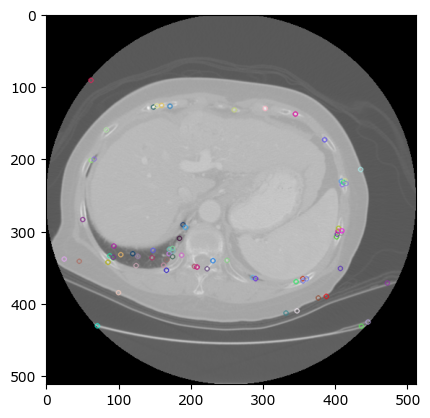

In [12]:
import numpy as np
import cv2
from sklearn.metrics import pairwise_distances_argmin_min

# Assuming you have pixel arrays for the reference image and post-treatment images
reference_pixel_array = prepro_ref_array # Pixel array for the reference image
post_treatment_pixel_arrays = prepro_arrays  # List of pixel arrays for post-treatment images

# Initialize SIFT or SURF detector
sift = cv2.SIFT_create()
# surf = cv2.xfeatures2d.SURF_create()

# Find keypoints and descriptors for the reference image
kp, des = sift.detectAndCompute(prepro_ref_array, None)

sourcedst = cv2.drawKeypoints(prepro_ref_array, kp,prepro_ref_array)

plt.imshow(sourcedst, cmap = "gray")
#plt.imshow(prepro_ref_array, cmap = "gray")

In [13]:
closest_image_idx = None
min_distance = 1e5


# Need to draw only good matches, so create a mask


for idx, pixel_array in enumerate(post_treatment_pixel_arrays):
    # Find keypoints and descriptors for the post-treatment image
    kp2, des2 = sift.detectAndCompute(pixel_array, None)
    
    # Match features
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(des, des2, k=2)
    
    # Apply ratio test to find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    # Calculate distance based on matched keypoints
    distance = len(good_matches)
    
    # Update closest image if necessary
    if distance < min_distance:
        min_distance = distance
        closest_image_idx = idx

# Display the closest section (assuming you have a function to convert pixel array to image)
closest_image = post_treatment_pixel_arrays[closest_image_idx]
#cv2.imshow("Closest Section", closest_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


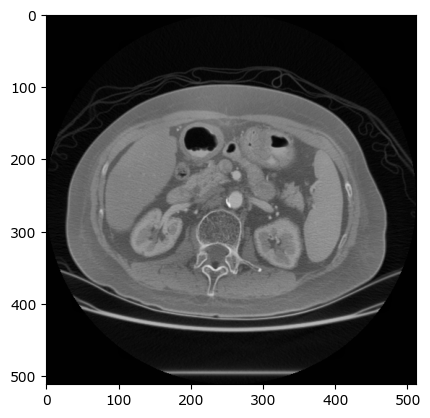

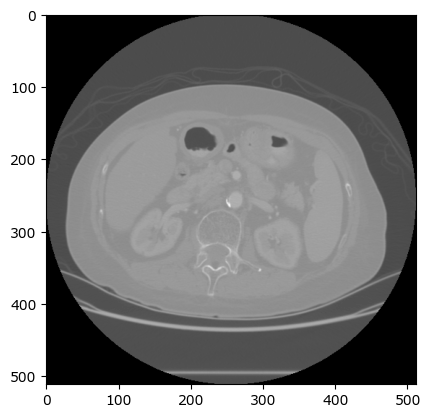

In [24]:
from skimage import exposure

exposure.equalize_adapthist(post_treatment_pixel_arrays[58])

im_adapthist = exposure.equalize_adapthist(post_ct_df_list[25]['pixel_array'].iloc[58])

plt.imshow(im_adapthist, cmap='gray')

plt.figure()

plt.imshow(post_treatment_pixel_arrays[58],cmap = 'gray')

In [14]:
closest_image_idx

58

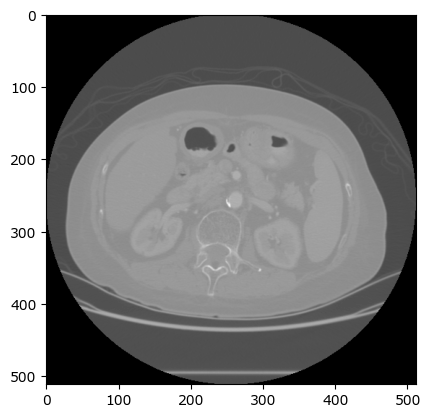

In [17]:
plt.imshow(post_treatment_pixel_arrays[58], cmap = "gray")

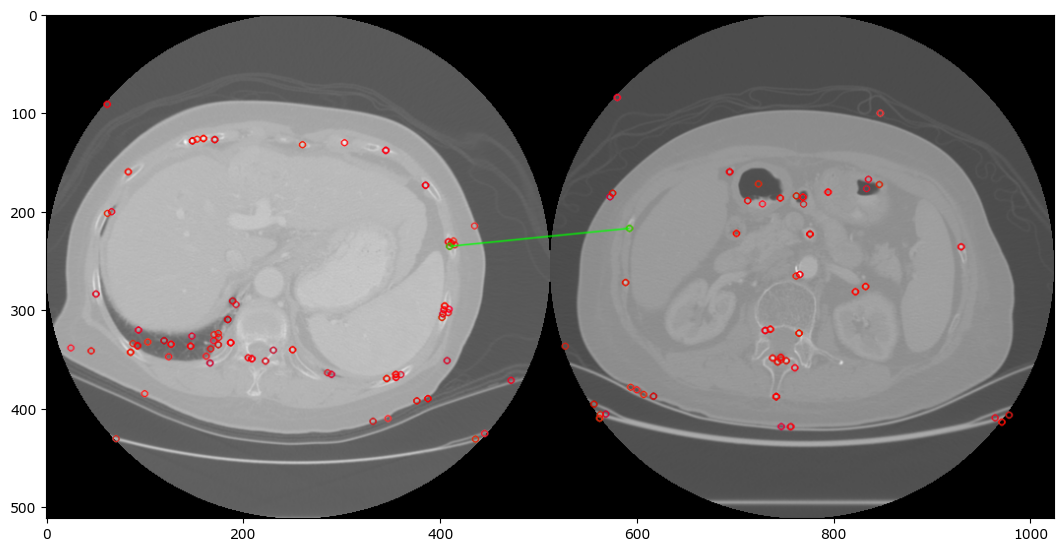

In [18]:
## Plot matching 


# ETAPE 3 : matching

kp2, des2 = sift.detectAndCompute(post_treatment_pixel_arrays[58], None)

dest_ct=cv2.drawKeypoints(post_treatment_pixel_arrays[58],kp2,post_treatment_pixel_arrays[58])

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des,des2,k=2)


# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(sourcedst,kp,dest_ct,kp2,matches,None,**draw_params)

plt.figure(figsize=(13,25))
plt.imshow(img3,)
plt.show()